## Creating a dataset

The main purpose of this notebook is to combine a few datasets of interest to our project into a single one with the aim of creating a minimal working example and a baseline model. I had to make some options throughout the process, and some have some shortcomings that we will have to address. For instance, I am using all the data available for a given street when creating a model, but some features of a street change with time (perhaps some speed humps were installed last year in the street we are studying). Any model based on the dataset created in this notebook will ignore this considerations. 

The baseline model and MWE will both try to estimate the number of crashes occurring in a given street of NYC, at a given time of day during the period of one month.

The only data sources used were the ones from the NYC OpenData project. The datasets are directly loaded into memory at the start of the notebook. I used GeoPandas to join these atasets. Joining by the road name is not reliable, as the road names are not uniform across different datasets. (They are not even uniform WITHIN the crash dataset.) Moreover, not all datasets include road names.

One thing that I want to do soon is to create a class with methods that streamline this whole data engineering process. At the moment, it is rather cumbersome to use this notebook for data wrangling. A centralized set of methods to reduce boilerplate code would likely improve our efficiency.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [2]:
CRASHES_ENDPOINT = "h9gi-nx95"
CENTERLINE_ENDPOINT = "8rma-cm9c"
SPEEDLIMITS_ENDPOINT = "iw2g-2u2i"
SPEEDHUMPS_ENDPOINT = "5z7h-pt8n"

In [3]:
from data_downloader import OpenDataDownloader
from dotenv import load_dotenv
import os

load_dotenv()

nyc_app_token = os.getenv("NYC_OPENDATA_APPTOKEN")

data_loader = OpenDataDownloader(nyc_app_token)

In [4]:
crashes = data_loader.load_data(CRASHES_ENDPOINT, limit=3000000)

In [5]:
NYC_EPSG = "EPSG:2263"
STD_EPSG = "EPSG:4326"

centerline = data_loader.load_geo_dataframe(
    CENTERLINE_ENDPOINT, geometry_column="the_geom", limit=3000000, to_crs=NYC_EPSG
)
speed_lims = data_loader.load_geo_dataframe(
    SPEEDLIMITS_ENDPOINT, geometry_column="the_geom", limit=3000000, to_crs=NYC_EPSG
)
humps = data_loader.load_geo_dataframe(
    SPEEDHUMPS_ENDPOINT, geometry_column="the_geom", limit=3000000, to_crs=NYC_EPSG
)

In [6]:
crashes.head()

,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,latitude,longitude,location,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-06-29T00:00:00.000,6:55,THROGS NECK BRIDGE,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-11T00:00:00.000,9:35,NaN,NaN,0,0,0,0,0,0,...,40.667202,-73.8665,"{'latitude': '40.667202', 'longitude': '-73.86...",1211 LORING AVENUE,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-12-14T00:00:00.000,8:13,SARATOGA AVENUE,DECATUR STREET,0,0,0,0,0,0,...,40.683304,-73.917274,"{'latitude': '40.683304', 'longitude': '-73.91...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


For the sake of this example, I will only keep a few columns. There are several other features of this dataset that we may be interested about. For instance, we may want to know how many people died in a given car crash so that we can rank each in terms of its severity.

In [7]:
columns_to_keep = ["crash_date", "crash_time", "latitude", "longitude"]

In [8]:
crashes = crashes[columns_to_keep]

We can only work with rows with non-null latitude and longitude entries.

In [9]:
crashes = crashes.dropna(subset=["longitude", "latitude"])
crashes.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1840116 entries, 3 to 2073638
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   crash_date  1840116 non-null  object
 1   crash_time  1840116 non-null  object
 2   latitude    1840116 non-null  object
 3   longitude   1840116 non-null  object
dtypes: object(4)
memory usage: 70.2+ MB


In [10]:
crashes_gdf = gpd.GeoDataFrame(
    crashes,
    geometry=gpd.points_from_xy(crashes["longitude"], crashes["latitude"]),
    crs=STD_EPSG,
)

crashes_gdf.to_crs(NYC_EPSG, inplace=True)

In [11]:
del crashes

In [17]:
import datetime


def create_datetime_feature(row: pd.DataFrame) -> datetime.datetime:
    year, month, day = list(map(int, row["crash_date"].split("T")[0].split("-")))
    hour, minute = list(map(int, row["crash_time"].split(":")))
    return datetime.datetime(year, month, day, hour, minute)

In [18]:
crashes_gdf["datetime"] = crashes_gdf[["crash_date", "crash_time"]].apply(
    create_datetime_feature, axis=1
)

In [20]:
crashes_gdf.drop(columns=["crash_date", "crash_time"], inplace=True)

In [21]:
centerline_cols_keep = [
    "rw_type",
    "bike_lane",
    "shape_leng",
    "trafdir",
    "geometry",
    "st_width",
]
centerline = centerline[centerline_cols_keep]

In [22]:
centerline.geometry.value_counts()

geometry
MULTILINESTRING ((1020363.754 220509.997, 1020...    2
MULTILINESTRING ((995384.564 237575.420, 99550...    2
MULTILINESTRING ((995508.586 237801.167, 99563...    2
MULTILINESTRING ((995634.569 238028.993, 99575...    2
MULTILINESTRING ((995222.714 237284.193, 99525...    2
                                                    ..
MULTILINESTRING ((980967.070 191446.957, 98088...    1
MULTILINESTRING ((959813.450 174070.377, 95979...    1
MULTILINESTRING ((993185.034 232807.373, 99318...    1
MULTILINESTRING ((997111.937 235749.663, 99710...    1
MULTILINESTRING ((1009309.441 248021.379, 1009...    1
Name: count, Length: 121678, dtype: int64

There are several duplicated roads in the `centerline` dataset. Perhaps each corresponds to a direction of traffic? For now, I will only keep the first copy.

In [23]:
centerline = centerline.drop_duplicates(subset=["geometry"])

In [24]:
speed_lims["centroid"] = speed_lims.geometry.centroid

In [25]:
speed_lims.rename(
    columns={"geometry": "road_geom", "centroid": "geometry"}, inplace=True
)

In [26]:
centerline["buffered"] = centerline.geometry.buffer(32)
centerline.rename(
    columns={"geometry": "road_geom", "buffered": "geometry"}, inplace=True
)

In [27]:
road_info = centerline.sjoin(speed_lims, how="left")

In [28]:
road_info.drop(
    columns=["shape_leng_right", "road_geom_right", "index_right"], inplace=True
)
road_info.rename(
    columns={"shape_leng_left": "shape_leng", "road_geom_left": "road_geom"},
    inplace=True,
)

In [29]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 261196 entries, 0 to 121905
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rw_type     261196 non-null  object  
 1   bike_lane   35825 non-null   object  
 2   shape_leng  261196 non-null  object  
 3   trafdir     261157 non-null  object  
 4   road_geom   261196 non-null  geometry
 5   st_width    261196 non-null  object  
 6   geometry    261196 non-null  geometry
 7   street      247500 non-null  object  
 8   postvz_sl   247500 non-null  object  
 9   postvz_sg   247500 non-null  object  
dtypes: geometry(2), object(8)
memory usage: 21.9+ MB


For the moment, I will fill null values in the speed limit column with the mode.

In [30]:
speed_lim_mode = road_info.postvz_sl.mode().iloc[0]
speed_lim_mode

'25'

In [31]:
road_info["postvz_sl"] = road_info["postvz_sl"].fillna(speed_lim_mode)

In [32]:
road_info["postvz_sl"] = road_info["postvz_sl"].astype(int)

In [33]:
road_info = road_info.groupby(
    by=[
        "rw_type",
        "bike_lane",
        "shape_leng",
        "trafdir",
        "geometry",
        "road_geom",
        "st_width",
    ],
    dropna=False,
    as_index=False,
)["postvz_sl"].mean()

In [34]:
road_info.columns

Index(['rw_type', 'bike_lane', 'shape_leng', 'trafdir', 'geometry',
       'road_geom', 'st_width', 'postvz_sl'],
      dtype='object')

In [35]:
humps = humps[["humps", "geometry"]]

In [36]:
# Group bys turn geo dataframes into regular dataframes

road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [37]:
humps["centroid"] = humps["geometry"].centroid
humps.rename(columns={"geometry": "road_geom", "centroid": "geometry"}, inplace=True)
humps.drop(columns=["road_geom"], inplace=True)

In [38]:
road_info = road_info.sjoin(humps, how="left")

In [39]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121814 entries, 0 to 121677
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   rw_type      121814 non-null  object  
 1   bike_lane    15688 non-null   object  
 2   shape_leng   121814 non-null  object  
 3   trafdir      121804 non-null  object  
 4   geometry     121814 non-null  geometry
 5   road_geom    121814 non-null  geometry
 6   st_width     121814 non-null  object  
 7   postvz_sl    121814 non-null  float64 
 8   index_right  4195 non-null    float64 
 9   humps        4195 non-null    object  
dtypes: float64(2), geometry(2), object(6)
memory usage: 10.2+ MB


In [40]:
road_info.road_geom.value_counts()

road_geom
MULTILINESTRING ((1038682.193 153036.382, 1038...    3
MULTILINESTRING ((1033263.313 151248.859, 1033...    3
MULTILINESTRING ((1038917.563 153012.307, 1038...    3
MULTILINESTRING ((989093.930 202786.694, 98946...    3
MULTILINESTRING ((1033263.313 151248.859, 1033...    3
                                                    ..
MULTILINESTRING ((991015.416 200270.174, 99113...    1
MULTILINESTRING ((1026875.484 208891.584, 1026...    1
MULTILINESTRING ((1010806.216 218841.206, 1010...    1
MULTILINESTRING ((982926.152 187113.168, 98295...    1
MULTILINESTRING ((1025371.127 214004.434, 1025...    1
Name: count, Length: 121678, dtype: int64

In [41]:
columns_to_groupby = list(road_info.columns)
columns_to_groupby.remove("index_right")
columns_to_groupby.remove("humps")
columns_to_groupby

['rw_type',
 'bike_lane',
 'shape_leng',
 'trafdir',
 'geometry',
 'road_geom',
 'st_width',
 'postvz_sl']

In [42]:
road_info["humps"] = road_info["humps"].fillna(0)
road_info["humps"] = road_info["humps"].astype(float)

In [43]:
road_info = road_info.groupby(by=columns_to_groupby, as_index=False, dropna=False)[
    "humps"
].sum()

In [44]:
road_info.humps.value_counts()

humps
0.0    117619
1.0      2623
2.0      1119
3.0       189
4.0        87
9.0        16
5.0         9
8.0         8
6.0         8
Name: count, dtype: int64

In [45]:
road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [46]:
road_info.road_geom.value_counts()

road_geom
MULTILINESTRING ((979522.293 189565.875, 97863...    1
MULTILINESTRING ((1033288.969 251636.684, 1033...    1
MULTILINESTRING ((993165.517 198810.190, 99316...    1
MULTILINESTRING ((982782.907 198677.700, 98279...    1
MULTILINESTRING ((934739.005 166936.419, 93474...    1
                                                    ..
MULTILINESTRING ((1015581.752 267292.839, 1015...    1
MULTILINESTRING ((983378.113 198714.222, 98340...    1
MULTILINESTRING ((983470.612 186474.070, 98351...    1
MULTILINESTRING ((974902.903 160965.516, 97490...    1
MULTILINESTRING ((1025923.485 240757.785, 1026...    1
Name: count, Length: 121678, dtype: int64

In [47]:
road_info.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121678 entries, 0 to 121677
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   rw_type     121678 non-null  object  
 1   bike_lane   15673 non-null   object  
 2   shape_leng  121678 non-null  object  
 3   trafdir     121668 non-null  object  
 4   geometry    121678 non-null  geometry
 5   road_geom   121678 non-null  geometry
 6   st_width    121678 non-null  object  
 7   postvz_sl   121678 non-null  float64 
 8   humps       121678 non-null  float64 
dtypes: float64(2), geometry(2), object(5)
memory usage: 8.4+ MB


In [48]:
road_info = gpd.GeoDataFrame(road_info, geometry=road_info.geometry, crs=NYC_EPSG)

In [49]:
crashes_road = road_info.sjoin(crashes_gdf, how="left")

In [50]:
crashes_road.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 6257156 entries, 0 to 121677
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   rw_type      6257156 non-null  object        
 1   bike_lane    1268856 non-null  object        
 2   shape_leng   6257156 non-null  object        
 3   trafdir      6256616 non-null  object        
 4   geometry     6257156 non-null  geometry      
 5   road_geom    6257156 non-null  geometry      
 6   st_width     6257156 non-null  object        
 7   postvz_sl    6257156 non-null  float64       
 8   humps        6257156 non-null  float64       
 9   index_right  6233710 non-null  float64       
 10  latitude     6233710 non-null  object        
 11  longitude    6233710 non-null  object        
 12  datetime     6233710 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(2), object(7)
memory usage: 668.3+ MB


In [51]:
crashes_road.drop(columns=["index_right"], inplace=True)

In [52]:
crashes_road.reset_index(inplace=True)
crashes_road.drop(columns=["index"], inplace=True)

In [53]:
del crashes_gdf, humps, road_info, centerline

In [54]:
crashes_road.head()

,rw_type,bike_lane,shape_leng,trafdir,geometry,road_geom,st_width,postvz_sl,humps,latitude,longitude,datetime
0,1,1,10.4998278111,TF,"POLYGON ((993192.181 198789.615, 993190.989 19...","MULTILINESTRING ((993165.517 198810.190, 99316...",40.0,25.0,0.0,NaN,NaN,NaT
1,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2021-07-25 12:23:00
2,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2023-09-25 20:45:00
3,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2022-02-17 04:46:00
4,1,1,10.5782844295,FT,"POLYGON ((982795.001 198709.159, 982798.126 19...","MULTILINESTRING ((982782.907 198677.700, 98279...",30.0,27.5,0.0,40.711998,-74.005264,2022-02-03 14:13:00


In [56]:
crashes_road["month"] = crashes_road.datetime.apply(lambda o: o.month)

In [57]:
crashes_road["hour"] = crashes_road.datetime.apply(lambda o: o.hour)

In [58]:
crashes_road["year"] = crashes_road.datetime.apply(lambda o: o.year)

In [59]:
crashes_road.info(show_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6257156 entries, 0 to 6257155
Data columns (total 15 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   rw_type     6257156 non-null  object        
 1   bike_lane   1268856 non-null  object        
 2   shape_leng  6257156 non-null  object        
 3   trafdir     6256616 non-null  object        
 4   geometry    6257156 non-null  geometry      
 5   road_geom   6257156 non-null  geometry      
 6   st_width    6257156 non-null  object        
 7   postvz_sl   6257156 non-null  float64       
 8   humps       6257156 non-null  float64       
 9   latitude    6233710 non-null  object        
 10  longitude   6233710 non-null  object        
 11  datetime    6233710 non-null  datetime64[ns]
 12  month       6233710 non-null  float64       
 13  hour        6233710 non-null  float64       
 14  year        6233710 non-null  float64       
dtypes: datetime64[ns](1), fl

<Axes: xlabel='month', ylabel='hour'>

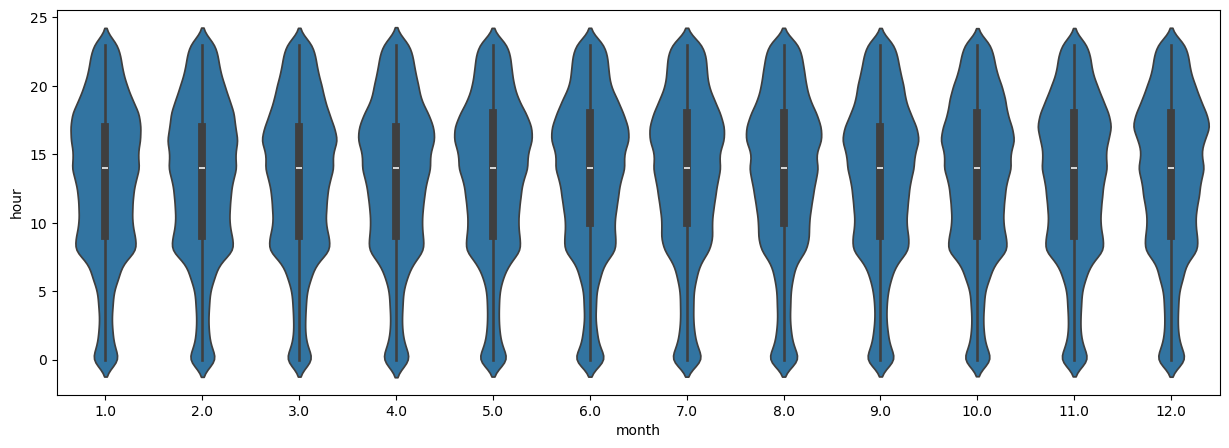

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
sns.violinplot(
    crashes_road.dropna(subset=["month"]), x="month", y="hour", bw_adjust=1.5
)

The distribution of crashes in NYC during the day does not change much from month to month, but it is clear that there are more crashes during peak times.

In [61]:
number_of_months = len(crashes_road[["month", "year"]].drop_duplicates())
number_of_months

142

In [62]:
crashes_road.columns
columns_to_grouby = [
    "rw_type",
    "bike_lane",
    "shape_leng",
    "trafdir",
    "geometry",
    "road_geom",
    "st_width",
    "postvz_sl",
    "humps",
    "hour",
]

In [63]:
crashes_road["crashes"] = crashes_road.hour.apply(lambda o: not np.isnan(o))

In [64]:
crashes_road_hour_count = crashes_road.groupby(
    by=columns_to_grouby, as_index=False, dropna=False
)["crashes"].sum()

In [65]:
del crashes_road

In [66]:
crashes_road_hour_count.sort_values("crashes", ascending=False)

,rw_type,bike_lane,shape_leng,trafdir,geometry,road_geom,st_width,postvz_sl,humps,hour,crashes
970351,1,NaN,474.559662707,TW,"POLYGON ((1012988.272 185000.542, 1012988.723 ...","MULTILINESTRING ((1012865.703 185460.115, 1012...",60.0,25.0,0.0,16.0,124
1127268,1,NaN,6528.61031702,TW,"POLYGON ((1019937.337 260087.035, 1019937.418 ...","MULTILINESTRING ((1019758.386 259418.315, 1019...",54.0,25.0,0.0,8.0,122
1183163,1,NaN,718.071632481,FT,"POLYGON ((994151.618 216413.573, 994154.291 21...","MULTILINESTRING ((993507.232 216732.034, 99413...",35.0,25.0,0.0,17.0,120
1127277,1,NaN,6528.61031702,TW,"POLYGON ((1019937.337 260087.035, 1019937.418 ...","MULTILINESTRING ((1019758.386 259418.315, 1019...",54.0,25.0,0.0,17.0,116
1302297,1,NaN,900.018865798,TW,"POLYGON ((986275.437 215565.184, 986272.768 21...","MULTILINESTRING ((987078.370 215157.316, 98629...",60.0,25.0,0.0,18.0,110
...,...,...,...,...,...,...,...,...,...,...,...
1428966,7,NaN,81.8783963972,NV,"POLYGON ((1006626.143 250052.108, 1006623.703 ...","MULTILINESTRING ((1006711.118 250029.585, 1006...",0.0,25.0,0.0,NaN,0
1428967,7,NaN,82.0148939754,NV,"POLYGON ((1021508.581 218714.616, 1021510.676 ...","MULTILINESTRING ((1021481.810 218630.749, 1021...",0.0,25.0,0.0,NaN,0
1428968,7,NaN,82.0792107377,NV,"POLYGON ((975187.337 169507.423, 975190.282 16...","MULTILINESTRING ((975099.432 169501.621, 97517...",0.0,25.0,0.0,NaN,0
1428969,7,NaN,83.3443638266,NV,"POLYGON ((1013118.330 218690.923, 1013117.335 ...","MULTILINESTRING ((1013149.771 218685.145, 1013...",0.0,25.0,0.0,NaN,0


In [67]:
crashes_road_hour_count["crashes"] = (
    crashes_road_hour_count["crashes"] / number_of_months
)

In [68]:
from pathlib import Path


def save_dataset(dataframe: pd.DataFrame | gpd.GeoDataFrame, file_name: str):
    data_folder = Path("./data")
    os.makedirs(data_folder, exist_ok=True)
    dataframe.to_csv(data_folder / file_name, index=False)

In [69]:
crashes_road_hour_count.drop(columns=["geometry", "road_geom"], inplace=True)

save_dataset(crashes_road_hour_count, "crashes_avg.csv")

#### Further comments

- Not all streets will have data for all times of the day. We may want to think about whether we should add one row per hour per street. The new added rows will have 0 crashes. 